In [1]:
import os
import sys
import time
import csv
from importlib import reload
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import assay
import util
import calibrate as cal

from sklearn.linear_model import Ridge, RidgeCV, LinearRegression
    
import numpy as np
import scipy as sc
import pandas as pd 

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams["font.size"] = 16

import seaborn as sns
sns.set_style('darkgrid')

In [2]:
reload(cal)
reload(assay)
order = 2
alpha = 0.1
# done v2: red 96 all, 192 all, 384 0, 2, 4, 6
# done v3: red all 0
n_trains = [384]
ntrain2reg = {24: 10, 48: 10, 96: 10, 192: 1, 384: 1}
n_seed = 5000
lmbdas = [6]
y_increment = 0.01
ys = np.arange(0, 1.7, y_increment)

for fitness_str in ['blue', 'red']:
    
    data = assay.PoelwijkData(fitness_str, order=order)
    ptrain_fn = lambda x: (1.0 / data.n) * np.ones([x.shape[0]])
    
    for t, n_train in enumerate(n_trains):

        reg = ntrain2reg[n_train]
        covint = cal.ConformalRidgeCovariateIntervention(ptrain_fn, ys, data.X_nxp, reg)
        covshift = cal.ConformalRidgeCovariateShift(ptrain_fn, ys, data.X_nxp, reg)

        for l, lmbda in enumerate(lmbdas):

            cslooset_s, csisset_s = [], []
            cilooset_s, ciisset_s = [], []
            ytest_s, predtest_s = np.zeros([n_seed]), np.zeros([n_seed])
            csloocov_s, csiscov_s = np.zeros([n_seed]), np.zeros([n_seed])
            ciloocov_s, ciiscov_s = np.zeros([n_seed]), np.zeros([n_seed])
            t0 = time.time()

            for seed in range(n_seed):
                
                Xtrain_nxp, ytrain_n, Xtest_1xp, ytest_1, pred_1 = cal.get_uniform_train_and_design_test(
                    data, n_train, reg, lmbda, seed=seed)
                ytest_s[seed] = ytest_1[0]
                predtest_s[seed] = pred_1[0]

                # get confidence set using covariate intervention
                cilooset, ciisset = covint.get_confidence_set(
                    Xtrain_nxp, ytrain_n, Xtest_1xp, lmbda, alpha=alpha, use_adaptive_score=False) 
                ciisset_s.append(ciisset)
                ciiscov_s[seed] = cal.is_covered(ytest_s[seed], ciisset, y_increment)
                cilooset_s.append(cilooset)
                ciloocov_s[seed] = cal.is_covered(ytest_s[seed], cilooset, y_increment)

                # get confidence set using covariate shift
                cslooset, csisset = covshift.get_confidence_set(
                    Xtrain_nxp, ytrain_n, Xtest_1xp, lmbda, alpha=alpha, use_adaptive_score=False) 
                csisset_s.append(csisset)
                csiscov_s[seed] = cal.is_covered(ytest_s[seed], csisset, y_increment)
                cslooset_s.append(cslooset)
                csloocov_s[seed] = cal.is_covered(ytest_s[seed], cslooset, y_increment)

                if (seed + 1) % 200 == 0:
                    print("{}, {}, {}. {} trials. CS IS, LOO coverage: {:.4f}, {:.4f}. CI IS, LOO coverage: {:.4f}, {:.4f}. {:.1f} s".format(
                        fitness_str, n_train, lmbda, seed + 1,
                        np.mean(csiscov_s[: seed + 1]), np.mean(csloocov_s[: seed + 1]),
                        np.mean(ciiscov_s[: seed + 1]), np.mean(ciloocov_s[: seed + 1]), time.time() - t0))

            np.savez('../results/113021/{}_n{}_lambda{}_alpha{}_gamma{}_2.npz'.format(
                fitness_str, n_train, lmbda, alpha, reg),
                     ytest_s=ytest_s, predtest_s=predtest_s,
                     ciisset_s=ciisset_s, ciiscov_s=ciiscov_s, cilooset_s=cilooset_s, ciloocov_s=ciloocov_s,
                     csisset_s=csisset_s, csiscov_s=csiscov_s, cslooset_s=cslooset_s, csloocov_s=csloocov_s, 
                    )

92 features
Loading estimated noise SE precomputed with order 7 and significance level 0.01
red, 384, 6. 200 trials. CS IS, LOO coverage: 0.8850, 0.8950. CI IS, LOO coverage: 0.8750, 0.8800. 2739.9 s
red, 384, 6. 400 trials. CS IS, LOO coverage: 0.8925, 0.9025. CI IS, LOO coverage: 0.8850, 0.8850. 5327.4 s
red, 384, 6. 600 trials. CS IS, LOO coverage: 0.9117, 0.9183. CI IS, LOO coverage: 0.9050, 0.9050. 7823.6 s
red, 384, 6. 800 trials. CS IS, LOO coverage: 0.9175, 0.9237. CI IS, LOO coverage: 0.9100, 0.9113. 10313.9 s
red, 384, 6. 1000 trials. CS IS, LOO coverage: 0.9120, 0.9210. CI IS, LOO coverage: 0.9050, 0.9090. 12811.8 s
red, 384, 6. 1200 trials. CS IS, LOO coverage: 0.9158, 0.9233. CI IS, LOO coverage: 0.9083, 0.9125. 15349.2 s
red, 384, 6. 1400 trials. CS IS, LOO coverage: 0.9157, 0.9229. CI IS, LOO coverage: 0.9064, 0.9121. 17934.0 s
red, 384, 6. 1600 trials. CS IS, LOO coverage: 0.9213, 0.9263. CI IS, LOO coverage: 0.9119, 0.9163. 20423.0 s
red, 384, 6. 1800 trials. CS IS, LO

## debugging

92 features
Loading estimated SE precomputed with order 7 and significance level 0.01


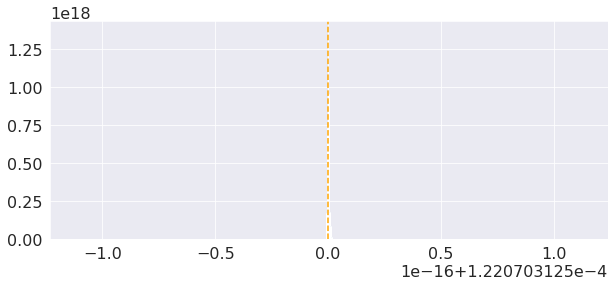

In [29]:
seed = 0
lmbda = 1e-14
fitness_str = 'blue'
order = 2
n_train = 48
np.random.seed(seed)
model = Ridge(alpha=10, fit_intercept=True)

data = assay.PoelwijkData(fitness_str, order=order)
train_idx = np.random.choice(data.n, n_train, replace=False)
Xtrain_nxp, ytrain_n = data.X_nxp[train_idx], data.y_n[train_idx]

# train model (exclude intercept feature)
model.fit(Xtrain_nxp[:, 1 :], ytrain_n)

# construct test covariate distribution
predall_n = model.predict(data.X_nxp[:, 1 :])
punnorm_n = np.exp(lmbda * predall_n)
Z = np.sum(punnorm_n)
plt.figure(figsize=(10, 4));
plt.hist(punnorm_n / Z, density=True);
plt.axvline(1 / data.n, linestyle='--', color='orange');

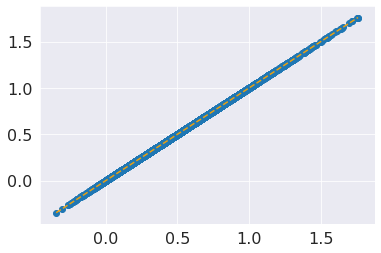

In [23]:
A = cal.get_invcov_dot_xt(Xtrain_nxp, gamma=10)
beta_p = A.dot(ytrain_n)
predall2_n = data.X_nxp.dot(beta_p)
plt.scatter(predall_n, predall2_n);
util.plot_xy(predall_n, predall2_n)

checking empirical samples from uniform distribution over Poelwijk data

92 features
Loading estimated noise SE precomputed with order 7 and significance level 0.01


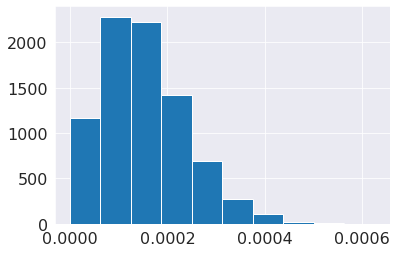

In [17]:
n_seed = 16000
lmbda = 0
data = assay.PoelwijkData("blue", order=2)
x2count = {tuple(x): 0 for x in data.X_nxp}

for seed in range(n_seed):
    Xtrain_nxp, ytrain_n, Xtest_1xp, ytest_1, pred_1 = cal.get_uniform_train_and_design_test(
            data, n_train, reg, lmbda, seed=seed)
    x2count[tuple(Xtest_1xp[0])] += 1.
for x, count in x2count.items():
    x2count[x] /= n_seed
plt.hist(x2count.values());

(array([  16.,  164.,  579., 1605., 2216., 2151., 1047.,  340.,   69.,
           5.]),
 array([9.450e-05, 1.003e-04, 1.061e-04, 1.119e-04, 1.177e-04, 1.235e-04,
        1.293e-04, 1.351e-04, 1.409e-04, 1.467e-04, 1.525e-04]),
 <a list of 10 Patch objects>)

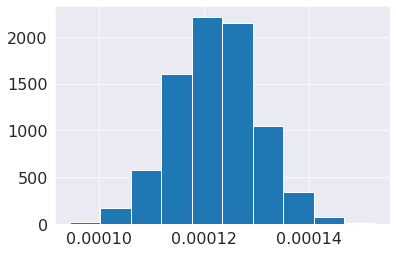

In [30]:
n_seed = 2000000
test_idx = np.random.choice(data.n, size=n_seed, replace=True)
x2countgt = {idx: np.where(test_idx == idx)[0].size / n_seed for idx in range(data.n)}
plt.hist(x2countgt.values());

In [5]:
# comparing naive, shift, intervention on uniform test data
reload(cal)
reload(assay)
order = 2
alpha = 0.1
n_train = 96
reg = 10
n_seed = 10000
lmbda =  0
y_increment = 0.01
ys = np.arange(0, 1.7, y_increment)
fitness_str = 'blue'
data = assay.PoelwijkData(fitness_str, order=order)
ptrain_fn = lambda x: (1.0 / data.n) * np.ones([x.shape[0]])

confnaive = cal.ConformalRidgeNaive(ptrain_fn, ys, data.X_nxp, reg)
# confshift = cal.ConformalRidgeCovariateShift(ptrain_fn, ys, data.X_nxp, reg)
confint = cal.ConformalRidgeCovariateIntervention(ptrain_fn, ys, data.X_nxp, reg)
naivecov_s, shiftcov_s, intcov_s = np.zeros([n_seed]), np.zeros([n_seed]), np.zeros([n_seed])
t0 = time.time()

for seed in range(n_seed):
    
#     train_idx = np.random.choice(data.n, n_train, replace=True)
#     test_idx = np.random.choice(data.n, 1, replace=True)
#     Xtrain_nxp, ytrain_n = data.X_nxp[train_idx], data.get_measurements(train_idx)
#     Xtest_1xp, ytest_1 = data.X_nxp[test_idx], data.get_measurements(test_idx)
    Xtrain_nxp, ytrain_n, Xtest_1xp, ytest_1, pred_1 = cal.get_uniform_train_and_design_test(
    data, n_train, reg, lmbda, seed=seed)

#     naiveset, _ = confnaive.get_confidence_set(
#         Xtrain_nxp, ytrain_n, Xtest_1xp, lmbda, alpha=alpha, use_adaptive_score=False) 
#     naivecov_s[seed] = cal.is_covered(ytest_1[0], naiveset, y_increment)
    
#     _, shiftset = confshift.get_confidence_set(
#         Xtrain_nxp, ytrain_n, Xtest_1xp, lmbda, alpha=alpha, use_adaptive_score=False) 
#     shiftcov_s[seed] = cal.is_covered(ytest_1[0], shiftset, y_increment)
    
    _, intset = confint.get_confidence_set(
        Xtrain_nxp, ytrain_n, Xtest_1xp, lmbda, alpha=alpha, use_adaptive_score=False) 
    intcov_s[seed] = cal.is_covered(ytest_1[0], intset, y_increment)

    if (seed + 1) % 100 == 0:
        print("{}, {}, {}. {} trials. naive, shift, intervention coverage: {:.4f}, {:.4f}, {:.4f}. {:.1f} s".format(
            fitness_str, n_train, lmbda, seed + 1,
            np.mean(naivecov_s[: seed + 1]), np.mean(shiftcov_s[: seed + 1]), np.mean(intcov_s[: seed + 1]),
            time.time() - t0))

92 features
Loading estimated noise SE precomputed with order 7 and significance level 0.01


KeyboardInterrupt: 

In [23]:
# comparing naive, shift, intervention on uniform test data
reload(cal)
reload(assay)
order = 2
alpha = 0.1
n_train = 96
reg = 10
n_seed = 10000
lmbda =  0
y_increment = 0.01
ys = np.arange(0, 1.7, y_increment)
fitness_str = 'blue'
data = assay.PoelwijkData(fitness_str, order=order)
ptrain_fn = lambda x: (1.0 / data.n) * np.ones([x.shape[0]])

model = Ridge(alpha=reg, fit_intercept=True)
confnaive = cal.ConformalNaive(model, ptrain_fn, ys, data.X_nxp[:, 1 :])
naivecov_s, shiftcov_s, intcov_s = np.zeros([n_seed]), np.zeros([n_seed]), np.zeros([n_seed])
t0 = time.time()

for seed in range(n_seed):

    Xtrain_nxp, ytrain_n, Xtest_1xp, ytest_1, pred_1 = cal.get_uniform_train_and_design_test(
        data, n_train, reg, lmbda, seed=seed)

    naiveset, _, _ = confnaive.get_confidence_set(
        Xtrain_nxp[:, 1 :], ytrain_n, Xtest_1xp[:, 1 :], lmbda, alpha=alpha, use_loo_score=True,
        print_every=80, verbose=False,
        use_adaptive_score=False) 
    naivecov_s[seed] = cal.is_covered(ytest_1[0], naiveset, y_increment)
    
    if (seed + 1) % 10 == 0:
        print("{}, {}, {}. {} trials. naive {:.4f}. {:.1f} s".format(
            fitness_str, n_train, lmbda, seed + 1, np.mean(naivecov_s[: seed + 1]), time.time() - t0))

92 features
Loading estimated noise SE precomputed with order 7 and significance level 0.01
blue, 96, 0. 10 trials. naive 0.8000. 137.9 s
blue, 96, 0. 20 trials. naive 0.8500. 271.8 s
blue, 96, 0. 30 trials. naive 0.9000. 406.0 s
blue, 96, 0. 40 trials. naive 0.9250. 537.6 s
blue, 96, 0. 50 trials. naive 0.9000. 670.5 s
blue, 96, 0. 60 trials. naive 0.9000. 807.5 s
blue, 96, 0. 70 trials. naive 0.8857. 940.4 s
blue, 96, 0. 80 trials. naive 0.8875. 1076.0 s
blue, 96, 0. 90 trials. naive 0.9000. 1210.7 s
blue, 96, 0. 100 trials. naive 0.9000. 1347.4 s
blue, 96, 0. 110 trials. naive 0.9091. 1479.3 s
blue, 96, 0. 120 trials. naive 0.9000. 1616.0 s
blue, 96, 0. 130 trials. naive 0.8923. 1749.1 s
blue, 96, 0. 140 trials. naive 0.9000. 1885.9 s
blue, 96, 0. 150 trials. naive 0.9067. 2021.1 s
blue, 96, 0. 160 trials. naive 0.9125. 2155.8 s
blue, 96, 0. 170 trials. naive 0.9118. 2294.8 s
blue, 96, 0. 180 trials. naive 0.9167. 2426.8 s
blue, 96, 0. 190 trials. naive 0.9158. 2556.4 s
blue, 96, 0.

KeyboardInterrupt: 

In [12]:
# weird bug where set doesn't include point prediction
fitness_str = 'blue'
order = 2
n_train = 96
reg = 10
lmbda = 2
y_increment = 0.01
ys = np.arange(0, 1.7, y_increment)
n_seed = 100

data = assay.PoelwijkData(fitness_str, order=order)
ptrain_fn = lambda x: (1.0 / data.n) * np.ones([x.shape[0]])

for seed in range(n_seed):

    covint = cal.ConformalRidgeCovariateIntervention(ptrain_fn, ys, data.X_nxp, reg)
    Xtrain_nxp, ytrain_n, Xtest_1xp, ytest_1, pred_1 = cal.get_uniform_train_and_design_test(
        data, n_train, reg, lmbda, seed=seed)

    # get confidence set using covariate intervention
    cilooset, ciisset = covint.get_confidence_set(
        Xtrain_nxp, ytrain_n, Xtest_1xp, lmbda, alpha=alpha, use_adaptive_score=False)

    print(seed, ytest_1, pred_1, cal.is_covered(pred_1[0], cilooset, y_increment))

92 features
Loading estimated noise SE precomputed with order 7 and significance level 0.01
0 [1.40621265] [1.39316181] True
1 [0.28010473] [0.44637736] True
2 [0.2825834] [0.50753413] True
3 [1.38458664] [1.339484] True
4 [1.32894699] [0.8863157] True
5 [1.47596702] [0.993887] True
6 [1.23004767] [0.84374503] True
7 [1.35351874] [1.23898536] True
8 [0.5004279] [0.70796092] True
9 [0.20999028] [0.25264717] True
10 [0.2170059] [0.32326771] True
11 [0.26514002] [0.26904248] True
12 [0.28445091] [0.25656766] True
13 [0.32929453] [0.44179981] True
14 [0.32447145] [0.28521148] True
15 [0.66414235] [1.22182991] True
16 [0.25544768] [0.3700104] True
17 [0.87636342] [0.89294932] True
18 [1.31818795] [1.15242884] True
19 [1.49738717] [1.48965024] True
20 [0.23626218] [0.6617397] True
21 [1.42441082] [1.13794754] True
22 [0.20776025] [0.30840542] True
23 [1.41997168] [0.98595294] True
24 [0.95930174] [1.27874731] True
25 [1.35537194] [1.01819375] True
26 [0.25765805] [0.34078806] True
27 [1.3589